# Does the bootstrap methodology have the capability to replicate real world resampling of training dataset?

When a statistical learning method is fit on a training dataset the parameters of the model are determined. However there is an uncertainty associated with the parameter values as a different training dataset will lead to slightly different parameter values. For cases where this uncertainty cannot be estimated via analytical methods a practical approach will be to resample the training dataset multiple times and fit the model to get its parameter values thereby eventually estimating the associated uncertainty. However almost always such resampling of the training set is not possible and here the bootstrap methodology comes in. The methodology assumes that it can well replicate the variance of the training dataset. It is this assumption that we would like to empirically test.

## Measuring variance of training datasets:

One training datasets vary from each other in the sense that they have different distributions. But they are also similar in some basic characteristics on account of belonging to the same population. To quantify this difference let us assume a training set with $n_{samples}$ samples of a single feature and decide on some parameters that capture the simmilarities and dissimilarities of training sets -

<ol>
    <li>Features like mean, variance, quartile ranges are characteristic of the population and remain almost the same for sample sets drawn from the same population.</li>
    <li>Each training set will give us a histogram plot. We can form a metric that will measure the dissimilarity of the histogram plots between two training sets to quantify the difference of the two training sets. Such differences between all pairs of training sets among $n_{sets}$ training sets will also help us study the dissimilarity of training sets taken from same population. Suppose for each bucket $i$ the histogram bars of two training sets, 1 and 2, have heights $h_{i1}$ and $h_{i2}$ respectively. $D_{12} = \sum_{i} {{(h_{i1}-h_{i2})}^2}$ is the dissimilarity metric between training sets 1 and 2.</li>
    </ol>

## Strategy:

Given the above metrics our strategy would be the following -
<ul>
    <li>Select $n_{sets}$ of training sets from the population (simulated distribution in our case). We call this selection approach the naive approach.</li>
    <li>Generate $n_{sets}$ training sets using the bootstrap approach. We call this the bootstrap appproach.</li>
    <li>For both the naive and bootstrap approaches the distribution of $n_{sets}$ metrics are compared. How similar the distributions are will indicate how closely the bootsrap approach replicates the naive one.</li>
    </ul>

## Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

## Functions to implement the strategy:

In [2]:
def discretizeSeriesCount(ser,gap,precision):
    lowerEnd = np.floor(ser.min()*(10**precision))/(10**precision)-(gap/2)
    upperEnd = np.ceil(ser.max()*(10**precision))/(10**precision)+gap
    bins = np.arange(lowerEnd,upperEnd,gap)
    labels = np.around(np.arange(lowerEnd+(gap/2),upperEnd-(gap/2),gap),precision)
    return pd.cut(ser,bins,labels=labels).value_counts()

def dissimilarityMetric(x1,x2,gap,precision):
    ser1=discretizeSeriesCount(x1,gap,precision)
    ser2=discretizeSeriesCount(x2,gap,precision)
    return (ser1.subtract(ser2,fill_value=0)**2).sum()

def generatingTrainingSets(numOfSets,func,*args,**kwargs):
    return [func(*args,**kwargs) for i in range(numOfSets)]

def generatingBootstrapSets(y,numOfSets):
    return [np.random.choice(y,size=len(y)) for i in range(numOfSets)]

def findVariability(gap,precision,numOfSets,func,*args,**kwargs):
    trainingSets = generatingTrainingSets(numOfSets,func,*args,**kwargs)
    bootstrapSets = generatingBootstrapSets(trainingSets[0],numOfSets)
    
    meansOfTrainingSets = [trainingSet.mean() for trainingSet in trainingSets]
    meansOfbootstrapSets = [bootstrapSet.mean() for bootstrapSet in bootstrapSets]
    
    trainingQ0,trainingQ25,trainingQ50,trainingQ75,training100 = np.quantile(trainingSets,[0.0,0.25,0.50,0.75,1.0],axis=-1)
    bootstrapQ0,bootstrapQ25,bootstrapQ50,bootstrapQ75,bootstrapQ100 = np.quantile(bootstrapSets,[0.0,0.25,0.50,0.75,1.0],axis=-1)
    
    trainingSTDs = np.std(trainingSets,axis=-1)
    bootstrapSTDs = np.std(bootstrapSets,axis=-1)
    
    trainingDissimilarities = []
    for i in range(len(trainingSets)):
        for j in range(i+1, len(trainingSets)):
            trainingDissimilarities.append(dissimilarityMetric(trainingSets[i],trainingSets[j],gap,precision))
    
    bootstrapDissimilarities = []
    for i in range(len(bootstrapSets)):
        for j in range(i+1,len(bootstrapSets)):
            bootstrapDissimilarities.append(dissimilarityMetric(bootstrapSets[i],bootstrapSets[j],gap,precision))
    
    trainingProps = {
        'mean':meansOfTrainingSets,
        'Q0':trainingQ0,
        'Q25':trainingQ25,
        'Q50':trainingQ50,
        'Q75':trainingQ75,
        'Q100':training100,
        'STD':trainingSTDs,
        'dissimilarityMetric':trainingDissimilarities
    }
    
    bootstrapProps = {
        'mean':meansOfbootstrapSets,
        'Q0':bootstrapQ0,
        'Q25':bootstrapQ25,
        'Q50':bootstrapQ50,
        'Q75':bootstrapQ75,
        'Q100':bootstrapQ100,
        'STD':bootstrapSTDs,
        'dissimilarityMetric':bootstrapDissimilarities
    }
    
    return trainingProps,bootstrapProps

## Plots:

### Training set size = 1000

In [3]:
trainingProps, bootstrapProps = findVariability(0.1,1,100,np.random.uniform,low=0.0,high=10.0,size=1000)

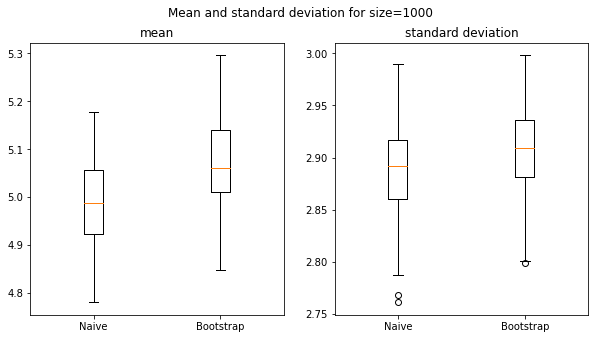

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.boxplot([trainingProps['mean'],bootstrapProps['mean']],labels=['Naive','Bootstrap'])
ax1.set_title('mean')
ax2.boxplot([trainingProps['STD'],bootstrapProps['STD']],labels=['Naive','Bootstrap'])
ax2.set_title('standard deviation')
fig.suptitle('Mean and standard deviation for size=1000')
fig.savefig('C:/Users/bubai/ISLRLearning/LabWork/Notebook/Blog requirements/Capability of bootstrap/Mean_and_STD_Size_1000')

''

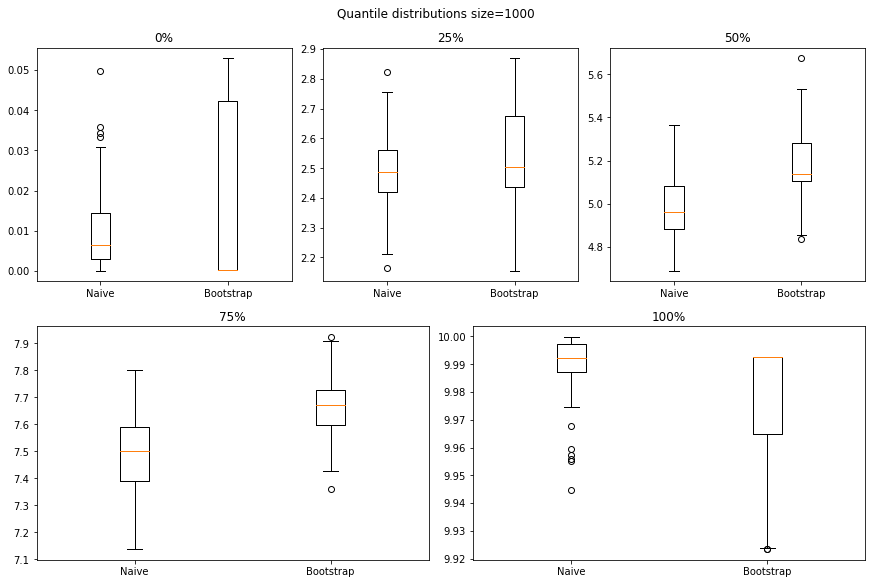

In [5]:
fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = GridSpec(2, 6, figure=fig)
ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0,2:4])
ax3 = fig.add_subplot(gs[0,4:])
ax4 = fig.add_subplot(gs[1,:3])
ax5 = fig.add_subplot(gs[1,3:])
ax1.boxplot([trainingProps['Q0'],bootstrapProps['Q0']],labels=['Naive','Bootstrap'])
ax1.set_title('0%')
ax2.boxplot([trainingProps['Q25'],bootstrapProps['Q25']],labels=['Naive','Bootstrap'])
ax2.set_title('25%')
ax3.boxplot([trainingProps['Q50'],bootstrapProps['Q50']],labels=['Naive','Bootstrap'])
ax3.set_title('50%')
ax4.boxplot([trainingProps['Q75'],bootstrapProps['Q75']],labels=['Naive','Bootstrap'])
ax4.set_title('75%')
ax5.boxplot([trainingProps['Q100'],bootstrapProps['Q100']],labels=['Naive','Bootstrap'])
ax5.set_title('100%')
fig.suptitle('Quantile distributions size=1000')
fig.savefig('C:/Users/bubai/ISLRLearning/LabWork/Notebook/Blog requirements/Capability of bootstrap/Quantiles_Size_1000')
;

''

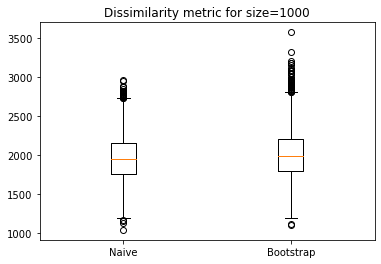

In [6]:
fig, ax1 = plt.subplots()
ax1.boxplot([trainingProps['dissimilarityMetric'],bootstrapProps['dissimilarityMetric']],labels=['Naive','Bootstrap'])
ax1.set_title('Dissimilarity metric for size=1000')
fig.savefig('C:/Users/bubai/ISLRLearning/LabWork/Notebook/Blog requirements/Capability of bootstrap/DissimilarityMetric_Size_1000')
;

### Training set size = 10

In [7]:
trainingProps, bootstrapProps = findVariability(0.1,1,100,np.random.uniform,low=0.0,high=10.0,size=10)

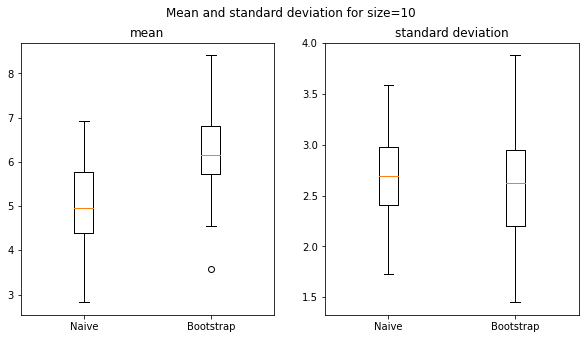

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.boxplot([trainingProps['mean'],bootstrapProps['mean']],labels=['Naive','Bootstrap'])
ax1.set_title('mean')
ax2.boxplot([trainingProps['STD'],bootstrapProps['STD']],labels=['Naive','Bootstrap'])
ax2.set_title('standard deviation')
fig.suptitle('Mean and standard deviation for size=10')
fig.savefig('C:/Users/bubai/ISLRLearning/LabWork/Notebook/Blog requirements/Capability of bootstrap/Mean_and_STD_Size_10')

''

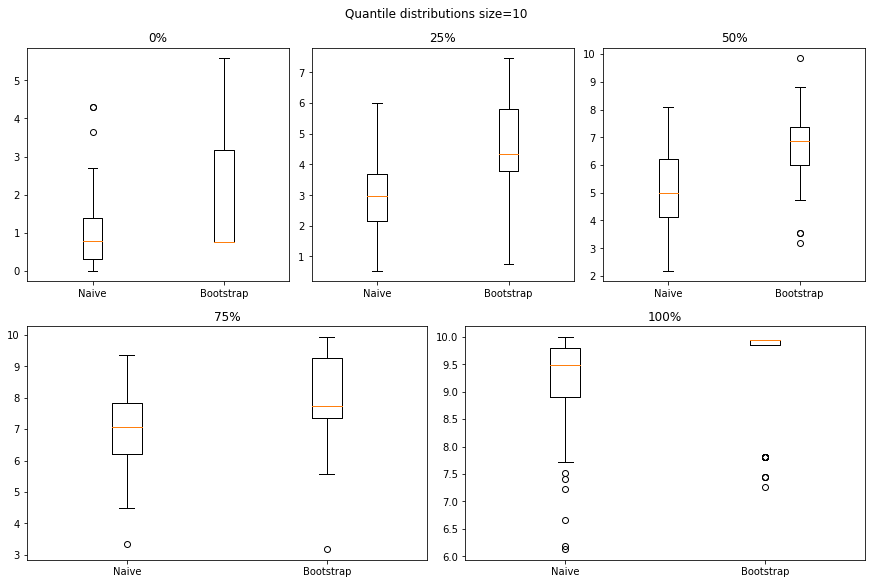

In [9]:
fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = GridSpec(2, 6, figure=fig)
ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0,2:4])
ax3 = fig.add_subplot(gs[0,4:])
ax4 = fig.add_subplot(gs[1,:3])
ax5 = fig.add_subplot(gs[1,3:])
ax1.boxplot([trainingProps['Q0'],bootstrapProps['Q0']],labels=['Naive','Bootstrap'])
ax1.set_title('0%')
ax2.boxplot([trainingProps['Q25'],bootstrapProps['Q25']],labels=['Naive','Bootstrap'])
ax2.set_title('25%')
ax3.boxplot([trainingProps['Q50'],bootstrapProps['Q50']],labels=['Naive','Bootstrap'])
ax3.set_title('50%')
ax4.boxplot([trainingProps['Q75'],bootstrapProps['Q75']],labels=['Naive','Bootstrap'])
ax4.set_title('75%')
ax5.boxplot([trainingProps['Q100'],bootstrapProps['Q100']],labels=['Naive','Bootstrap'])
ax5.set_title('100%')
fig.suptitle('Quantile distributions size=10')
fig.savefig('C:/Users/bubai/ISLRLearning/LabWork/Notebook/Blog requirements/Capability of bootstrap/Quantiles_Size_10')
;

''

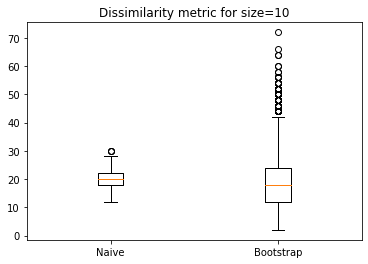

In [10]:
fig, ax1 = plt.subplots()
ax1.boxplot([trainingProps['dissimilarityMetric'],bootstrapProps['dissimilarityMetric']],labels=['Naive','Bootstrap'])
ax1.set_title('Dissimilarity metric for size=10')
fig.savefig('C:/Users/bubai/ISLRLearning/LabWork/Notebook/Blog requirements/Capability of bootstrap/DissimilarityMetric_Size_10')
;

The difference in the distributions of naive and bootstrap approaches go up by a factor of ~10 as size changes from 1000 to 10. It shows that as size becomes small bootstrap becomes inefficient.

## Conclusion:

Bootstrap is a good replacement for the naive approach. It uses random choice on a single training set to effectively replicate the event of selecting multiple training sets. However, as training set size becomes small it looses its edge.